In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
# Set Random Seeds
tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
np.random.seed(42)
# run the Enable Deterministic Operations Function
tf.config.experimental.enable_op_determinism()

from tensorflow.keras import layers 
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import optimizers 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn import set_config
set_config(transform_output = 'pandas')
pd.set_option('display.max_colwidth', 250)

# Vectorization Layer

In [2]:
df = pd.read_csv('Data/spooky.csv', index_col='id')
df

,text,author
id,,
id26305,"This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.",EAP
id17569,It never once occurred to me that the fumbling might be a mere mistake.,HPL
id11008,"In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.",EAP
id27763,"How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering and fair.",MWS
id12958,"Finding nothing else, not even gold, the Superintendent abandoned his attempts; but a perplexed look occasionally steals over his countenance as he sits thinking at his desk.",HPL
...,...,...
id17718,"I could have fancied, while I looked at it, that some eminent landscape painter had built it with his brush.",EAP
id08973,The lids clenched themselves together as if in a spasm.,EAP
id05267,"Mais il faut agir that is to say, a Frenchman never faints outright.",EAP


In [3]:
df.duplicated().sum()

0

In [4]:
# Determine the sequence length of each document in the corpus by using a lambda function to split the text on the spaces
seq_length = df['text'].map(lambda x : len(x.split()))
# Determine the range of sequence lengths
range_of_lengths = max(seq_length) - min(seq_length)
print(f"Range of sequence lengths: {range_of_lengths} with maximum length = {max(seq_length)} and minimum length = {min(seq_length)}")
# Determine the average of sequence lengths
average_of_lengths = seq_length.mean()
print("Average of sequence lengths:", round(average_of_lengths,2))

Range of sequence lengths: 859 with maximum length = 861 and minimum length = 2
Average of sequence lengths: 26.73


In [5]:
df['author'].value_counts()

EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64

In [6]:
# Use the RandomUnderSampler to balance the data based on the "author" column.
rus = RandomUnderSampler(random_state = 42)
df, _ = rus.fit_resample(df, df['author'])
df['author'].value_counts()

EAP    5635
HPL    5635
MWS    5635
Name: author, dtype: int64

In [7]:
# Change the author strings to integers using the following mapping: EAP: 0, HPL: 1, MWS: 2
## Mapping dictionary
author_mapping = {'EAP': 0, 'HPL': 1, 'MWS': 2}

## Replace author strings with integers based on the mapping
df['author'] = df['author'].map(author_mapping)

df.head()

,text,author
id,,
id22483,"He then asked me, suddenly, if I had observed any thing peculiar at the scene of the atrocity.",0
id18809,"Through the exertions of Beauvais, the matter was industriously hushed up, as far as possible; and several days had elapsed before any public emotion resulted.",0
id16322,"The cold was intense, and obliged me to wrap up closely in an overcoat.",0
id13423,"I observed that, upon her first elevation of the glass, she had seemed satisfied with a momentary inspection of my person, and was withdrawing the instrument, when, as if struck by a second thought, she resumed it, and so continued to regard me w...",0
id09553,There can be no doubt that the consciousness of the rapid increase of my superstition for why should I not so term it?,0


In [8]:
# Define X as the values from the "text" column. Define y as the "author" column.

X = df['text'].values
y = df['author']

In [9]:
# Convert to a dataset object using Dataset.from_tensor_slices()
ds = tf.data.Dataset.from_tensor_slices((X,y))
ds

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [10]:
# Shuffle dataset
ds = ds.shuffle(buffer_size=len(ds),reshuffle_each_iteration=False) 

# Set the ratio of the train, validation, test split
split_train = .7
split_val =  .2
split_test =  1 -( split_train + split_val )

# Calculate the number of samples for training and validation data 
n_train_samples =  int(len(ds) * split_train)
n_val_samples = int(len(ds) * split_val)
n_test_samples = len(ds) -(n_train_samples + n_val_samples)

# Set the batch size
BATCH_SIZE =32


import math
# math.ceil will round up
# How many batches? 
n_train_batches = math.ceil(n_train_samples/BATCH_SIZE)
n_val_batches = math.ceil(n_val_samples/BATCH_SIZE)
n_test_batches = math.ceil(n_test_samples/BATCH_SIZE)

print(f"    - train:\t{n_train_samples} samples \t({n_train_batches} batches)")
print(f"    - val:  \t{n_val_samples} samples \t({n_val_batches} batches)")
print(f"    - test: \t{n_test_samples} samples \t({n_test_batches} batches)")

    - train:	11833 samples 	(370 batches)
    - val:  	3381 samples 	(106 batches)
    - test: 	1691 samples 	(53 batches)


In [11]:
# Use take and skip to define each set
train_ds = ds.take(n_train_samples).batch(batch_size=BATCH_SIZE)

# Skip over the training batches and take the validation batches
val_ds = ds.skip(n_train_samples).take(n_val_samples).batch(batch_size=BATCH_SIZE)

# Skipver the train and validation batches, the remaining are the test batches
test_ds = ds.skip(n_train_samples + n_val_samples).batch(batch_size=BATCH_SIZE)

In [12]:
# Define sequence length as a variable for future use
SEQUENCE_LENGTH = 100
# Create text Vectorization layer
sequence_vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="int",
    output_sequence_length= SEQUENCE_LENGTH)


In [13]:
# Obtain the text from the training dataset using a lambda function
ds_texts = train_ds.map(lambda x ,y : x) 


In [14]:
# Train (adapt) the vectorization layer on the text data
sequence_vectorizer.adapt(ds_texts)

In [15]:
# Get vocabulary size
VOCAB_SIZE =  sequence_vectorizer.vocabulary_size()
VOCAB_SIZE

20976

In [16]:
# Create a look-up dictionary that will allow you to look up the word associated with an integer. 

vocab = sequence_vectorizer.get_vocabulary()
int_to_str = {idx: word for idx, word in enumerate(vocab)}

int_to_str


{0: '',
 1: '[UNK]',
 2: 'the',
 3: 'of',
 4: 'and',
 5: 'to',
 6: 'i',
 7: 'a',
 8: 'in',
 9: 'was',
 10: 'that',
 11: 'my',
 12: 'it',
 13: 'he',
 14: 'had',
 15: 'with',
 16: 'his',
 17: 'as',
 18: 'for',
 19: 'but',
 20: 'which',
 21: 'not',
 22: 'me',
 23: 'at',
 24: 'from',
 25: 'by',
 26: 'on',
 27: 'this',
 28: 'is',
 29: 'her',
 30: 'be',
 31: 'were',
 32: 'have',
 33: 'you',
 34: 'all',
 35: 'an',
 36: 'we',
 37: 'or',
 38: 'no',
 39: 'when',
 40: 'him',
 41: 'one',
 42: 'so',
 43: 'they',
 44: 'been',
 45: 'could',
 46: 'would',
 47: 'she',
 48: 'there',
 49: 'upon',
 50: 'more',
 51: 'its',
 52: 'their',
 53: 'now',
 54: 'what',
 55: 'some',
 56: 'our',
 57: 'into',
 58: 'if',
 59: 'them',
 60: 'who',
 61: 'are',
 62: 'will',
 63: 'than',
 64: 'then',
 65: 'only',
 66: 'very',
 67: 'up',
 68: 'before',
 69: 'man',
 70: 'about',
 71: 'even',
 72: 'these',
 73: 'out',
 74: 'yet',
 75: 'your',
 76: 'time',
 77: 'did',
 78: 'any',
 79: 'old',
 80: 'said',
 81: 'might',
 82: 'li

In [17]:
# What word is associated with integer 1000?
int_to_str[1000]


'occasion'

In [18]:
# Obtain the vectorized result of the sample text: "Text Vectorization is an essential tool for converting text into a format that machine learning models can use."
sequence = sequence_vectorizer(["Text Vectorization is an essential tool for converting text into a format that machine learning models can use."])
sequence

<tf.Tensor: shape=(1, 100), dtype=int64, numpy=
array([[ 6345,     1,    28,    35,  6996, 13401,    18,     1,  6345,
           57,     7,     1,    10,   833,  3862, 16160,   122,   521,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int64)>

# LSTM and GRU Models

Now you will try two different models to classify the data:

1) **LSTM**

- Define a function to build and compile a simple LSTM mo    del
- Use the pre-trained text vectorization layer from the practice assign    ment
- Create an embedding layerwith `output_dim=     150`
- Add an LSTM layer with 128     units
- Add an appropriate outpu    t layer
- Compile the model ith he `adam` opimizer, `loss = "sparse_categorical_crosentrop"`, and `metrics = "c    curacy"`
- Include an early stopping callback with a patience of 3
- Build, Fit, and Evaluate the model

2) **GRU**

- Define a function to build and compile a s
le GRU model
- Follow the same steps as above, but instead of an LSTM layer,
 use a GRU layer
- Build, Fit, and Evaluate the model


In [19]:
# Define a function for building an LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers, regularizers
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import custom_functions as fn

In [20]:
def build_lstm_model(text_vectorization_layer):
    

    # Define sequential model with pre-trained vectorization layer and embedding layer
    lstm_model = Sequential([text_vectorization_layer,
                  layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM, input_length=SEQUENCE_LENGTH)])
        
    # Add LSTM layer
    lstm_model.add(layers.LSTM(128))

    # Add output layer
    lstm_model.add(layers.Dense(len(classes), activation='softmax'))
 
    # Compile the model
    lstm_model.compile(optimizer=optimizers.legacy.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    lstm_model.summary()
    return lstm_model



In [21]:
def build_gru_model(text_vectorization_layer):
                
    gru_model = Sequential([text_vectorization_layer,
        tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM, input_length=SEQUENCE_LENGTH)])
    # Add GRU layer 
    gru_model.add(layers.GRU(128, return_sequences = True))   
    gru_model.add(layers.GlobalMaxPooling1D())
    # Output layer
    gru_model.add(layers.Dense(len(classes), activation='softmax'))
    
    optimizer = optimizers.legacy.Adam()
    gru_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    gru_model.summary()
    return gru_model

In [22]:
# Include callbacks
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]

In [23]:
# Define classes
classes = y.unique()
classes

array([0, 1, 2], dtype=int64)

In [24]:
# Define output dimension
EMBED_DIM =  150

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 100)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 100, 150)          3146400   
                                                                 
 lstm (LSTM)                 (None, 128)               142848    
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 3,289,635
Trainable params: 3,289,635
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
370/370 [==============================] - 48s 124ms/step - loss: 1.1001 - accuracy: 0.3256 - val_los

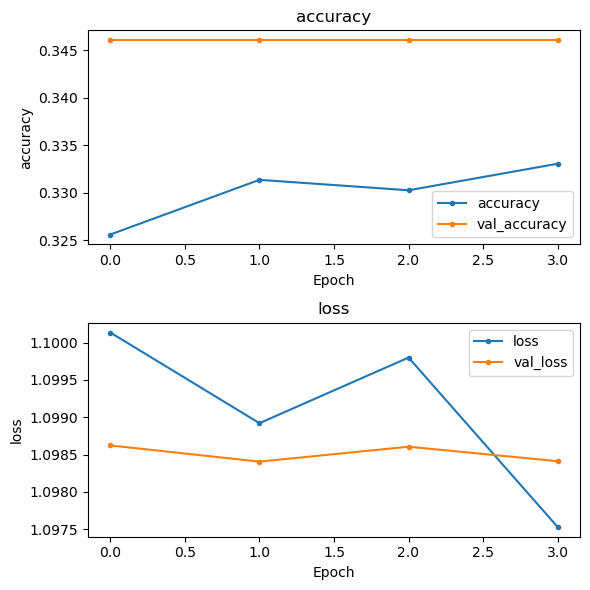


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.33      1.00      0.50      3906
           1       1.00      0.00      0.01      3952
           2       0.80      0.01      0.02      3975

    accuracy                           0.33     11833
   macro avg       0.71      0.34      0.17     11833
weighted avg       0.71      0.33      0.17     11833



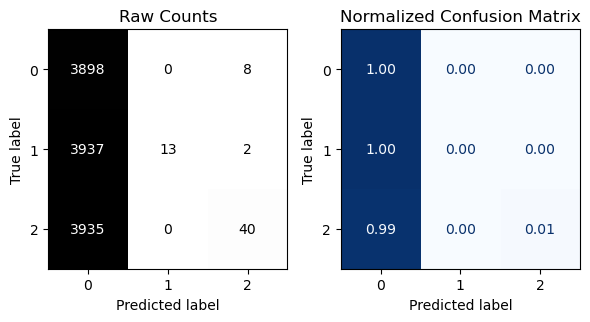


- Evaluating Training Data:
370/370 [==============================] - 11s 29ms/step - loss: 1.0966 - accuracy: 0.3339
{'loss': 1.0965535640716553, 'accuracy': 0.3338967263698578}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.33      0.99      0.50       559
           1       0.00      0.00      0.00       560
           2       0.44      0.01      0.01       572

    accuracy                           0.33      1691
   macro avg       0.26      0.33      0.17      1691
weighted avg       0.26      0.33      0.17      1691



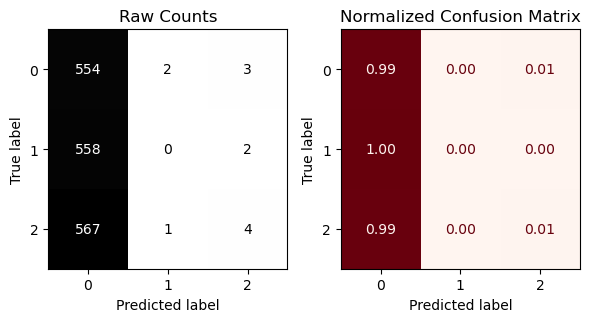


- Evaluating Test Data:
53/53 [==============================] - 2s 31ms/step - loss: 1.0988 - accuracy: 0.3300
{'loss': 1.0988247394561768, 'accuracy': 0.3299822509288788}


In [25]:
# Build the lstm model and specify the vectorizer
lstm_model = build_lstm_model(sequence_vectorizer)

# Defien number of epocs
EPOCHS = 30

# Fit the model
history = lstm_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks())

# Obtain the results
results = fn.evaluate_classification_network(lstm_model, X_train=train_ds, X_test=test_ds, history=history);


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 100)              0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 100, 150)          3146400   
                                                                 
 gru (GRU)                   (None, 100, 128)          107520    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 3,254,307
Trainable params: 3,254,307
No

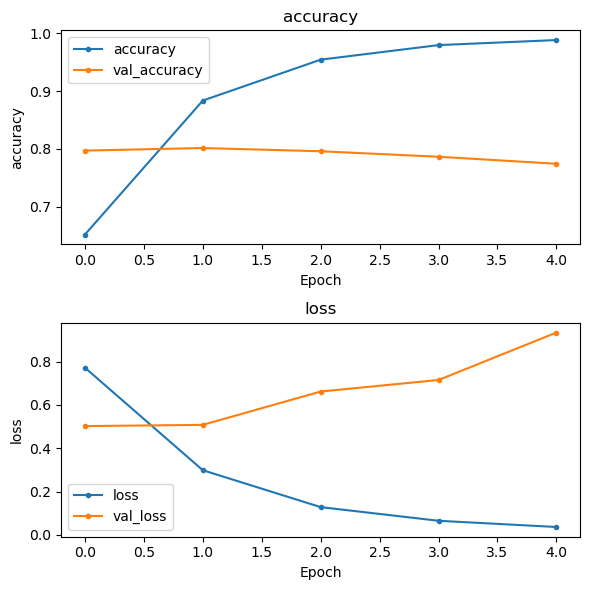


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3906
           1       1.00      0.99      0.99      3952
           2       0.98      1.00      0.99      3975

    accuracy                           0.99     11833
   macro avg       0.99      0.99      0.99     11833
weighted avg       0.99      0.99      0.99     11833



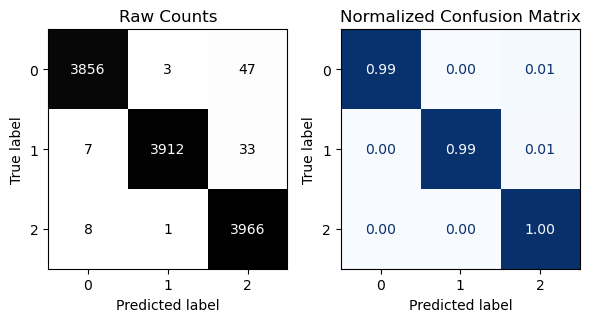


- Evaluating Training Data:
370/370 [==============================] - 9s 25ms/step - loss: 0.0292 - accuracy: 0.9916
{'loss': 0.029211396351456642, 'accuracy': 0.9916335940361023}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.72      0.76       559
           1       0.85      0.73      0.78       560
           2       0.72      0.90      0.80       572

    accuracy                           0.78      1691
   macro avg       0.79      0.78      0.78      1691
weighted avg       0.79      0.78      0.78      1691



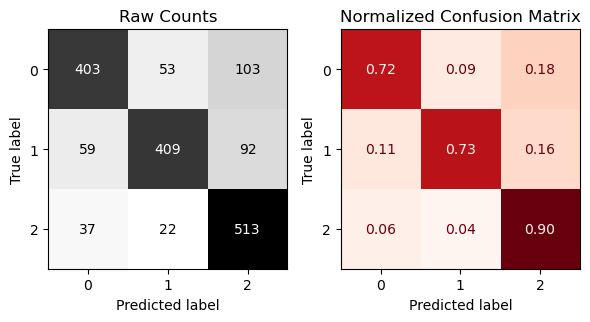


- Evaluating Test Data:
53/53 [==============================] - 1s 26ms/step - loss: 0.8984 - accuracy: 0.7836
{'loss': 0.8984168767929077, 'accuracy': 0.783560037612915}


In [26]:
# Build the model
gru_model = build_gru_model(sequence_vectorizer)
# Fit the model
EPOCHS = 30
history = gru_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks())

# Evaluate the model
results = fn.evaluate_classification_network(gru_model, X_train=train_ds, X_test=test_ds, history=history);
